## Challenge Kaggle
**Integrantes:** \\

**Daniel Peralta**  -  201621053-9 \\
**Philip Guerra**   -  201623003-3


El desafío consiste en predecir el precio de una casa a partir de metadata como el número de habitaciones, el número de baños y el área total de la casa. Se incluye también imágenes de la casa para mejorar las predicciones.

In [2]:
# hacer la conexión a Google Drive

from google.colab import drive

colab_flag = True

if (colab_flag):
    drive.mount('/content/drive')


path = '/content/drive/MyDrive/2021-1/Redes_neuronales_artificiales/Tarea1/Guerra'

Mounted at /content/drive


Partimos leyendo la metadata

In [4]:
#
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#Para trabajar sobre imagenes
import cv2
import random
import os
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [5]:
#data para el entrenamiento
data_house = pd.read_csv(path + '/metadata_casas_train.csv' ,header=0,engine='python')
print(data_house.shape)
data_house.head()

(443, 7)


,Unnamed: 0,cod_casa,habitaciones,banos,area,zipcode,precio
0,0,OC4U9J6C11R5715,4,4.0,4053,85255,869500
1,1,CQF44W2LE3S3NSC,4,3.0,3343,36372,865200
2,2,LT2Z9MOPF5KIM7T,3,4.0,3923,85266,889000
3,3,VUCNPXL2QMIA22A,5,5.0,4022,85262,910000
4,4,9CWP6T0SBBLGDBL,3,4.0,4116,85266,971226


In [6]:
#data de test
data_house_test = pd.read_csv(path + '/metadata_casas_test.csv' ,header=0,engine='python')
print(data_house_test.shape)
data_house_test.head()

(92, 6)


,Unnamed: 0,cod_casa,habitaciones,banos,area,zipcode
0,5,0R9Z8TJ4HVOWUAJ,4,5.0,4581,85266
1,18,3NYK5GU80YVQR1A,5,4.0,4190,85255
2,21,92S3N8VWFYQRI0Q,6,6.5,5963,85262
3,28,YZUR2KSKR0B46WU,4,4.0,4464,85377
4,35,HXFZX9UOWGJ7PTE,3,4.5,3893,85255


El desafío consiste en predecir el precio de la casa. Revisamos si existen celdas sin valores.

In [7]:
print("Número de datos NaN por feature (columna): \n")
print(data_house.isnull().sum(axis = 0))

Número de datos NaN por feature (columna): 

Unnamed: 0      0
cod_casa        0
habitaciones    0
banos           0
area            0
zipcode         0
precio          0
dtype: int64


In [8]:
#borramos la columna del ID 
del data_house["Unnamed: 0"]
#del data_house["zipcode"]

In [9]:
data_house.head()

,cod_casa,habitaciones,banos,area,zipcode,precio
0,OC4U9J6C11R5715,4,4.0,4053,85255,869500
1,CQF44W2LE3S3NSC,4,3.0,3343,36372,865200
2,LT2Z9MOPF5KIM7T,3,4.0,3923,85266,889000
3,VUCNPXL2QMIA22A,5,5.0,4022,85262,910000
4,9CWP6T0SBBLGDBL,3,4.0,4116,85266,971226


# Análisis de datos

Es importante anzalizar el comportamiento del precio con el resto de datos usando su distribución y su nivel de correlación.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-786638.5483934588, 6666638.548393458)

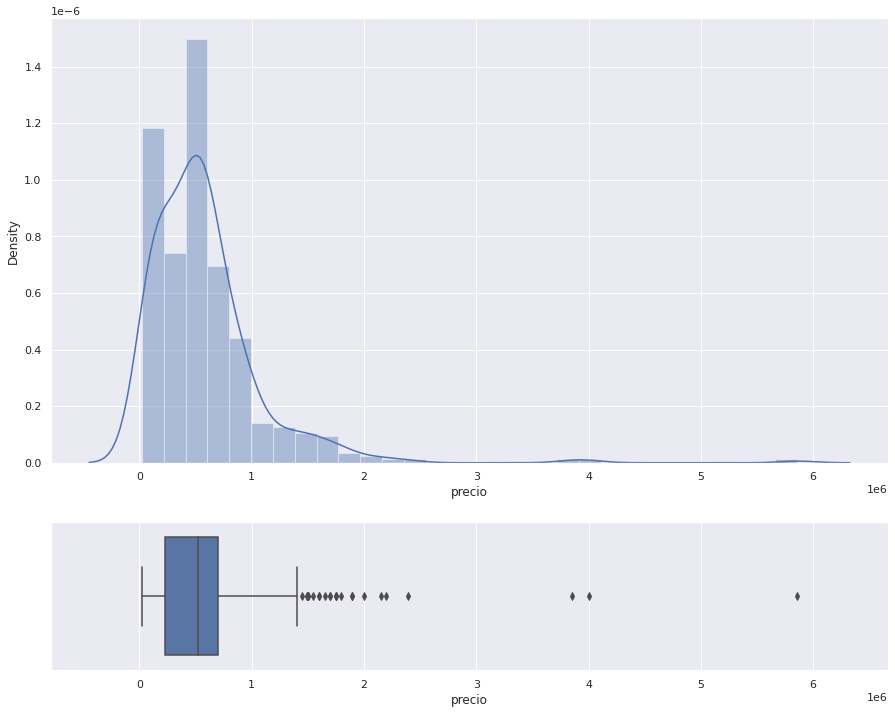

In [10]:
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
sns.distplot(data_house['precio'], bins=30,  ax=ax1)
sns.boxplot(x=data_house['precio'], ax=ax2)
ax2.set_xlim(ax1.get_xlim())

[]

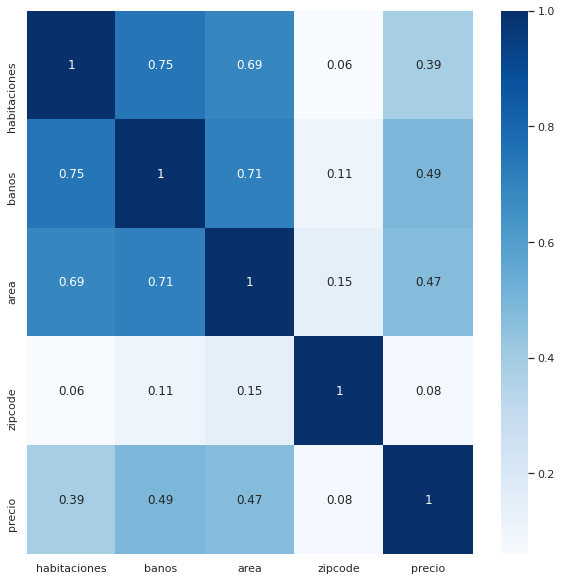

In [11]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(data=data_house.corr().round(2).abs(), annot=True, cmap=plt.cm.Blues)
plt.plot()

Respecto a las gráficas se desprende lo siguiente:


*   La concentración de la muestra está en torno a los 500000. 
* Poca relacion de zipcode con todas las variables, así que no la consideraremos.



Del gráfico de distribución respecto al precio se observa que hay una cantidad de datos que están fuera del intervalo donde se concentra la mayoría. Estos son los precios que están sobre los 2000000 ($). Se realizaron pruebas a la red quitando estos datos pero no se observaron mejorías, por lo que se decidió seguir considerando toda la data. Se adjunta el código con el que se eliminaron estos datos:

In [ ]:
# for i in range(len(data_house)):
#   if data_house['precio'][i] > 2000000:
#     data_house.drop(i,inplace=True)

Lo primero es cargar las imágenes

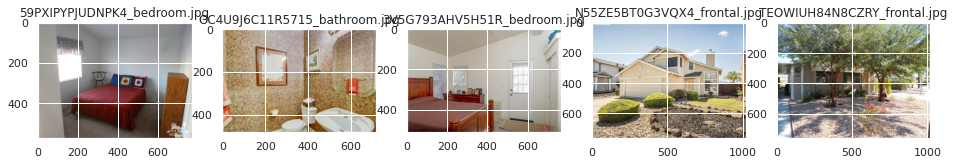

In [12]:
#revisamos unas imágenes aleatoriamente
img_folder = path+'/fotos-casas'

fig = plt.figure(figsize=(16, 16))

for i in range(5):
    file = random.choice(os.listdir(img_folder)) # elección aleatoria
    image_path= os.path.join(img_folder, file)
    
    img= mpimg.imread(image_path)
    
    ax = fig.add_subplot(1, 5,i+1)
    
    ax.title.set_text(file)
    plt.imshow(img)

Existen imágenes para bedroom, bathroom, frontal y kitchen, que estarán asociadas con la metadata mediante el código de la casa. La idea es tener dos entradas en paralelo. Por un lado, entrarán la casa con sus respectivas características numéricas, y por otro lado, entrará la misma casa pero con las imágenes de su parte frontal, cocina, habitación principal y baño principal. Se tendrán 443 datos con estas características. 

En primera instancia, la data de imagen cuenta con $(443+92) \cdot 4 = 2140$ datos en total, donde no se considerará la data para las 92 casas para las que no se posee información respecto al precio, que es el valor a predecir. Estos 92 valores son de la data de test.

Se tiene 4 fotos por casa.

In [13]:
#cargar las imagenes, se crean cuatro diccionarios para las 4 imagenes por casa
img_folder = path+'/fotos-casas'
def process_dataset(img_folder, width, height):
    data=[]
    data_bathroom = {}
    data_bedroom={}
    data_frontal = {}
    data_kitchen= {}
    ids = []   #nombre de las imagenes
   
    for filename in os.listdir(img_folder):
        
        filename2=filename[0:15]
        image_path = os.path.join(img_folder, filename)
        image = cv2.imread( image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #imágenes RGB

        # hacemos un resize del tamaño de las imágenes antes de ingresarlo a nuestro modelo
        image = cv2.resize(image, (width, height)) 
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 # escalar a [0, 1] 

        #se crean los diccionarios para los cuatro tipos de imágenes
        if filename.find("bathroom") > 0:
          data_bathroom[filename2] = image
          #data_bathroom.append([filename2,image])
        if filename.find("bedroom") > 0:
          data_bedroom[filename2] = image
          #data_bedroom.append([filename2,image])
        if filename.find("frontal") > 0:
          data_frontal[filename2] = image
          #data_frontal.append([filename2,image])
        if filename.find("kitchen") > 0:
          data_kitchen[filename2] = image
          #data_kitchen.append([filename2,image])

        data.append([filename,image])

        ids.append(filename)   #nombre de la imagen
    
    return np.array(data), np.array(ids), data_bathroom, data_bedroom, data_frontal, data_kitchen

img_data,  ids, img_data_bath, img_data_bed, img_data_front, img_data_kit  = process_dataset(img_folder, 52, 52)

print(img_data[0][1].shape)

(52, 52, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [14]:
len(img_data_bath),len(img_data_bed),len(img_data_front),len(img_data_kit)
#443+92 = 535

(535, 535, 535, 535)

Se crean las cuatro entradas de imágenes ordenadas según el código de la casa. Hay 443 datos para las casas y 535 datos de imágenes, así que se filtrarán por los 443 datos donde se conoce el precio.

In [17]:

img1=[]
img2=[]
img3=[]
img4=[]
for k in data_house.cod_casa:
  bed = img_data_bed[k]
  bath = img_data_bath[k]
  front = img_data_front[k]
  kit = img_data_kit[k]
  img1.append(bed)
  img2.append(bath)
  img3.append(front)
  img4.append(kit)

#lo mismo pero para los 92 casos de test
img1_test=[]
img2_test=[]
img3_test=[]
img4_test=[]
for k in data_house_test.cod_casa:
  bed1 = img_data_bed[k]
  bath1 = img_data_bath[k]
  front1 = img_data_front[k]
  kit1 = img_data_kit[k]
  img1_test.append(bed1)
  img2_test.append(bath1)
  img3_test.append(front1)
  img4_test.append(kit1)

Se pasan las imágenes a array.

In [18]:
image1=np.array(img1)
image2=np.array(img2)
image3=np.array(img3)
image4=np.array(img4)
image1_test=np.array(img1_test)
image2_test=np.array(img2_test)
image3_test=np.array(img3_test)
image4_test=np.array(img4_test)

In [19]:
print(image1.shape)
print(image1_test.shape)

(443, 52, 52, 3)
(92, 52, 52, 3)


In [20]:
#Se escalan los datos

ytrain = data_house.precio.to_numpy()
scalerY = StandardScaler().fit(ytrain.reshape(-1,1))
ytrain = scalerY.transform(ytrain.reshape(-1,1))

xtrain = data_house[['habitaciones','banos','area']].to_numpy()
xtest = data_house_test[['habitaciones','banos','area']].to_numpy()
scalerX = StandardScaler().fit(xtrain)
xtrain = scalerX.transform(xtrain)
xtest = scalerX.transform(xtest)

# Red con múltiples entradas

Se tendrán tres redes neuronales definidas mediante funciones, cada una con distintas carácterísticas. Todas las arquitecturas tienen 5 entradas, 4 de estas son imágenes y la otra es la metadata con el número de habitaciones, baños y área de la casa.


1.   La primera arquitectura es la base para las siguientes arquitecturas, cuenta con dos capas convolucionales por imagen, que se concatenan para pasar a una capa densa, y a la vez concatenarse con la entrada de las características numéricas de la casa.
2.   Para la segunda arquitectura se agrega mucha más produndidad para las imágenes (8 capas por imagen), mejorando respecto a la arquitectura original.
3.   Para la tercera arquitectura se agregan más capas respecto a la segunda en las ramas de las imágenes. También se agregan skipconnections para mejorar los resultados considerando que la red es profunda.


Model: "Challenge"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 52, 52, 3)]  0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 52, 52, 3)]  0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 52, 52, 3)]  0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 52, 52, 3)]  0                                            
__________________________________________________________________________________________

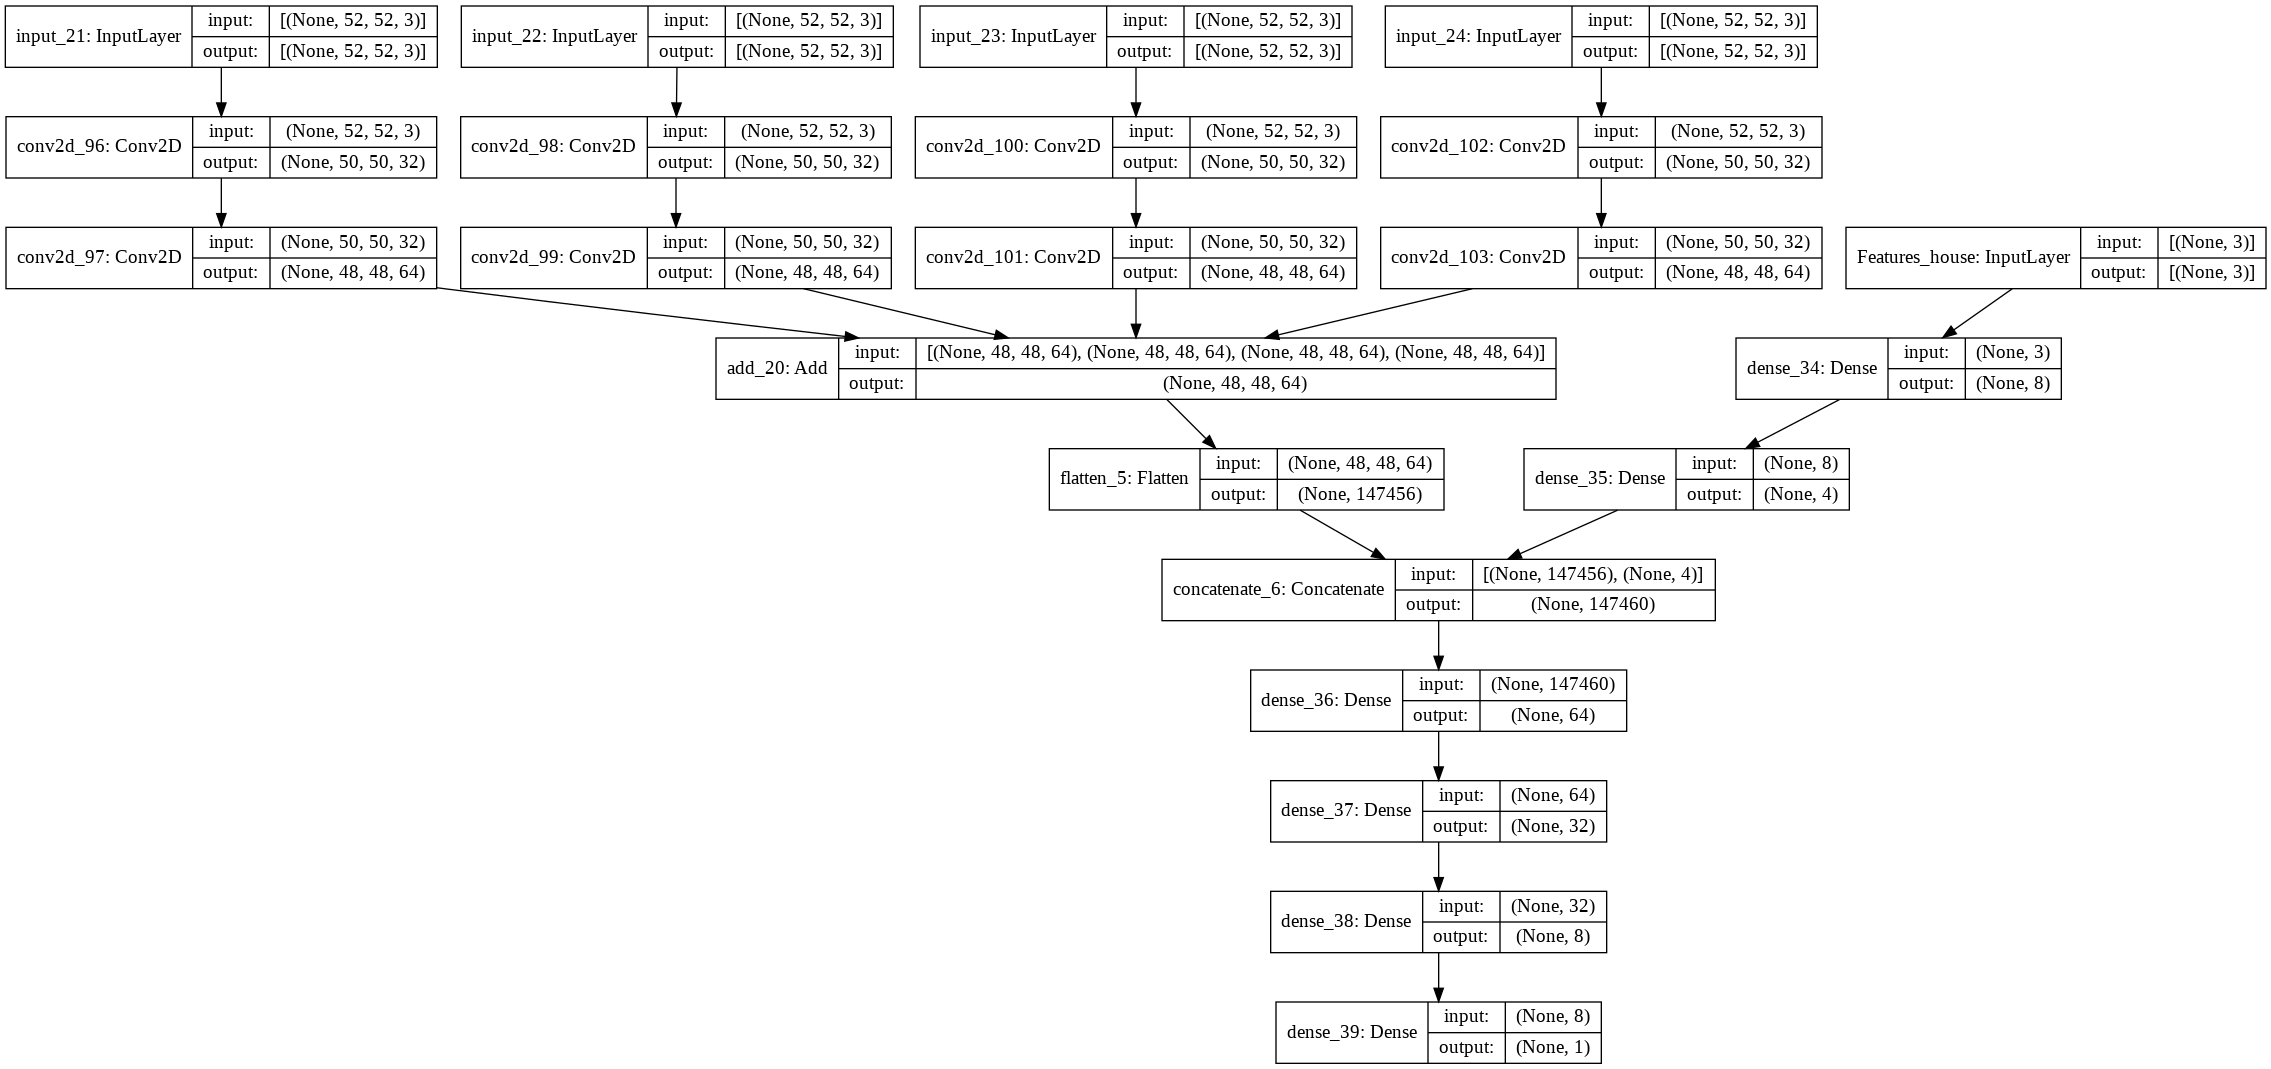

In [42]:

def get_model_multientradas1(activation_func,seed=1234):
    tf.random.set_seed(seed)
    #entradas
    input_feature = keras.Input(shape=(3,), name='Features_house')
    input2 = keras.Input(shape=(52,52,3,))    #images1
    input3 = keras.Input(shape=(52,52,3,))    #images2
    input4 = keras.Input(shape=(52,52,3,))    #images3
    input5 = keras.Input(shape=(52,52,3,))    #images4
    #rama_feature
    y = layers.Dense(8, activation=activation_func)(input_feature)
    y = layers.Dense(4, activation=activation_func)(y)
    #rama_1
    x1 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(input2)    
    x1 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x1)
    #rama_2
    x2 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(input3)    
    x2 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x2)
    #rama_3
    x3 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(input4)    
    x3 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x3)
    #rama_4
    x4 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(input5)    
    x4 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x4)

    combined = layers.add([x1,x2,x3,x4])
    #combined = layers.concatenate([x1,x2,x3,x4])

    flat = Flatten()(combined)

    combined2 = layers.concatenate([flat,y])

    x = layers.Dense(64, activation=activation_func)(combined2)
    x = layers.Dense(32, activation=activation_func)(x)
    x = layers.Dense(8, activation=activation_func)(x)

    output = layers.Dense(1,activation='linear')(x)
    model = keras.Model(inputs=[input_feature,input2,input3,input4,input5], outputs=output, name='Challenge')

    return model

######################################################
def get_model_multientradas2(activation_func,seed=1234):    
    tf.random.set_seed(seed)
    #entradas
    input_feature = keras.Input(shape=(3,), name='Features_house')
    input2 = keras.Input(shape=(52,52,3,))    #images1
    input3 = keras.Input(shape=(52,52,3,))    #images2
    input4 = keras.Input(shape=(52,52,3,))    #images3
    input5 = keras.Input(shape=(52,52,3,))    #images4
    #rama_feature
    y = layers.Dense(8, activation=activation_func)(input_feature)
    y = layers.Dense(4, activation=activation_func)(y)
    #rama_1
    x1 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(input2)
    x1 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(x1)  
    x1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x1)
    x1 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x1)  
    x1 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x1)
    x1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x1)
    x1 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func)(x1)  
    x1 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func)(x1)
    #rama_2
    x2 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(input3)    
    x2 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(x2)
    x2 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x2)
    x2 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x2)
    x2 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x2)
    x2 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x2)
    x2 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func)(x2)
    x2 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func)(x2)
    #rama_3
    x3 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(input4)    
    x3 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(x3)
    x3 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x3)
    x3 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x3)
    x3 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x3)
    x3 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x3)
    x3 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func)(x3)
    x3 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func)(x3)
    #rama_4
    x4 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(input5)    
    x4 = layers.Conv2D(filters = 32, kernel_size = 3, strides=(1, 1), activation = activation_func)(x4)
    x4 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x4)
    x4 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x4)
    x4 = layers.Conv2D(filters = 64, kernel_size = 3, strides=(1, 1), activation = activation_func)(x4)
    x4 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x4)
    x4 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func)(x4)
    x4 = layers.Conv2D(filters = 128, kernel_size = 3, strides=(1, 1), activation = activation_func)(x4)

    combined = layers.add([x1,x2,x3,x4])
    #combined = layers.concatenate([x1,x2,x3,x4])

    flat = Flatten()(combined)

    combined2 = layers.concatenate([flat,y])

    x = layers.Dense(64, activation=activation_func)(combined2)
    x = layers.Dense(32, activation=activation_func)(x)
    x = layers.Dense(16, activation=activation_func)(x)
    x = layers.Dense(8, activation=activation_func)(x)

    output = layers.Dense(1,activation='linear')(x)
    model = keras.Model(inputs=[input_feature,input2,input3,input4,input5], outputs=output, name='Challenge')

    return model
#####################################################
def get_model_multientradas3(activation_func,seed=1234):  
    tf.random.set_seed(seed)
    #entradas
    input_feature = keras.Input(shape=(3,), name='Features_house')
    input2 = keras.Input(shape=(52,52,3,))    #images1
    input3 = keras.Input(shape=(52,52,3,))    #images2
    input4 = keras.Input(shape=(52,52,3,))    #images3
    input5 = keras.Input(shape=(52,52,3,))    #images4
    #rama_feature
    y = layers.Dense(32, activation=activation_func)(input_feature)
    y = layers.Dense(16, activation=activation_func)(y)
    y = layers.Dense(8, activation=activation_func)(y)
    #rama_1
    x10 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding='same')(input2)
    x11 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding='same')(x10) 
    block_11 = layers.add([x10, x11]) #zero-padding shorcut 
    x12 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(block_11)
    x13 = layers.Conv2D(filters = 64, kernel_size = 3,  activation = activation_func, padding='same')(x12)  
    x14 = layers.Conv2D(filters = 64, kernel_size = 3,  activation = activation_func, padding='same')(x13)
    block_12 = layers.add([x13, x14]) #zero-padding shorcut 
    #x1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x1)
    x15 = layers.Conv2D(filters = 128, kernel_size = 3,  activation = activation_func, padding='same')(block_12)  
    x16 = layers.Conv2D(filters = 128, kernel_size = 3,  activation = activation_func, padding='same')(x15)
    block_13 = layers.add([x15, x16]) #zero-padding shorcut
    x17 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(block_13)
    x18 = layers.Conv2D(filters = 256, kernel_size = 3,  activation = activation_func, padding='same')(x17)  
    x19 = layers.Conv2D(filters = 256, kernel_size = 3,  activation = activation_func, padding='same')(x18)
    block_14 = layers.add([x18, x19]) #zero-padding shorcut
    #rama 2
    x20 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding='same')(input3)
    x21 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding='same')(x20) 
    block_21 = layers.add([x20, x21]) #zero-padding shorcut 
    x22 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(block_21)
    x23 = layers.Conv2D(filters = 64, kernel_size = 3,  activation = activation_func, padding='same')(x22)  
    x24 = layers.Conv2D(filters = 64, kernel_size = 3,  activation = activation_func, padding='same')(x23)
    block_22 = layers.add([x23, x24]) #zero-padding shorcut 
    #x1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x1)
    x25 = layers.Conv2D(filters = 128, kernel_size = 3,  activation = activation_func, padding='same')(block_22)  
    x26 = layers.Conv2D(filters = 128, kernel_size = 3,  activation = activation_func, padding='same')(x25)
    block_23 = layers.add([x25, x26]) #zero-padding shorcut
    x27 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(block_23)
    x28 = layers.Conv2D(filters = 256, kernel_size = 3,  activation = activation_func, padding='same')(x27)  
    x29 = layers.Conv2D(filters = 256, kernel_size = 3,  activation = activation_func, padding='same')(x28)
    block_24 = layers.add([x28, x29]) #zero-padding shorcut
    #rama 3
    x30 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding='same')(input4)
    x31 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding='same')(x30) 
    block_31 = layers.add([x30, x31]) #zero-padding shorcut 
    x32 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(block_31)
    x33 = layers.Conv2D(filters = 64, kernel_size = 3,  activation = activation_func, padding='same')(x32)  
    x34 = layers.Conv2D(filters = 64, kernel_size = 3,  activation = activation_func, padding='same')(x33)
    block_32 = layers.add([x33, x34]) #zero-padding shorcut 
    #x1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x1)
    x35 = layers.Conv2D(filters = 128, kernel_size = 3,  activation = activation_func, padding='same')(block_32)  
    x36 = layers.Conv2D(filters = 128, kernel_size = 3,  activation = activation_func, padding='same')(x35)
    block_33 = layers.add([x35, x36]) #zero-padding shorcut
    x37 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(block_33)
    x38 = layers.Conv2D(filters = 256, kernel_size = 3,  activation = activation_func, padding='same')(x37)  
    x39 = layers.Conv2D(filters = 256, kernel_size = 3,  activation = activation_func, padding='same')(x38)
    block_34 = layers.add([x38, x39]) #zero-padding shorcut

    #rama 3
    x40 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding='same')(input5)
    x41 = layers.Conv2D(filters = 32, kernel_size = 3, activation = activation_func, padding='same')(x40) 
    block_41 = layers.add([x40, x41]) #zero-padding shorcut 
    x42 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(block_41)
    x43 = layers.Conv2D(filters = 64, kernel_size = 3,  activation = activation_func, padding='same')(x42)  
    x44 = layers.Conv2D(filters = 64, kernel_size = 3,  activation = activation_func, padding='same')(x43)
    block_42 = layers.add([x43, x44]) #zero-padding shorcut 
    #x1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x1)
    x45 = layers.Conv2D(filters = 128, kernel_size = 3,  activation = activation_func, padding='same')(block_42)  
    x46 = layers.Conv2D(filters = 128, kernel_size = 3,  activation = activation_func, padding='same')(x45)
    block_43 = layers.add([x45, x46]) #zero-padding shorcut
    x47 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(block_43)
    x48 = layers.Conv2D(filters = 256, kernel_size = 3,  activation = activation_func, padding='same')(x47)  
    x49 = layers.Conv2D(filters = 256, kernel_size = 3,  activation = activation_func, padding='same')(x48)
    block_44 = layers.add([x48, x49]) #zero-padding shorcut

    
    combined = layers.add([block_14,block_24,block_34,block_44])
    

    flat = Flatten()(combined)

    combined2 = layers.concatenate([flat,y])

    x = layers.Dense(64, activation=activation_func)(combined2)
    x = layers.Dense(32, activation=activation_func)(x)
    x = layers.Dense(16, activation=activation_func)(x)
    x = layers.Dense(8, activation=activation_func)(x)

    output = layers.Dense(1,activation='linear')(x)
    model = keras.Model(inputs=[input_feature,input2,input3,input4,input5], outputs=output, name='Challenge')

    return model

model1 = get_model_multientradas1('relu')
model1.summary()
keras.utils.plot_model(model1, show_shapes=True)

# Red 1

Epoch 1/9
45/45 [==============================] - 16s 327ms/step - loss: 1.9493 - mean_squared_error: 1.9493 - val_loss: 0.3041 - val_mean_squared_error: 0.3041
Epoch 2/9
45/45 [==============================] - 14s 321ms/step - loss: 1.1697 - mean_squared_error: 1.1697 - val_loss: 0.2889 - val_mean_squared_error: 0.2889
Epoch 3/9
45/45 [==============================] - 14s 322ms/step - loss: 1.1480 - mean_squared_error: 1.1480 - val_loss: 0.3237 - val_mean_squared_error: 0.3237
Epoch 4/9
45/45 [==============================] - 14s 322ms/step - loss: 0.9711 - mean_squared_error: 0.9711 - val_loss: 0.2756 - val_mean_squared_error: 0.2756
Epoch 5/9
45/45 [==============================] - 14s 320ms/step - loss: 0.9242 - mean_squared_error: 0.9242 - val_loss: 0.4786 - val_mean_squared_error: 0.4786
Epoch 6/9
45/45 [==============================] - 14s 322ms/step - loss: 0.6928 - mean_squared_error: 0.6928 - val_loss: 0.3424 - val_mean_squared_error: 0.3424
Epoch 7/9
45/45 [===========

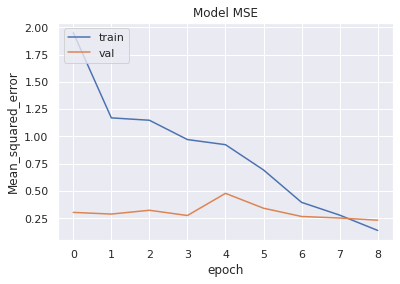

In [28]:
#prueba para el modelo 1
model1.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='MSE', metrics=['mean_squared_error'])
history = model1.fit(x=[xtrain,image1,image2,image3,image4], y = ytrain, validation_split=0.2,batch_size=8,epochs=9,verbose=1,)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('Mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim(0,2)
plt.show() 
red1_mse = history.history['mean_squared_error']
red1_mse_val = history.history['val_mean_squared_error']

# Red 2

Epoch 1/9
45/45 [==============================] - 21s 421ms/step - loss: 1.1836 - mean_squared_error: 1.1836 - val_loss: 0.2967 - val_mean_squared_error: 0.2967
Epoch 2/9
45/45 [==============================] - 18s 407ms/step - loss: 1.1779 - mean_squared_error: 1.1779 - val_loss: 0.2948 - val_mean_squared_error: 0.2948
Epoch 3/9
45/45 [==============================] - 18s 408ms/step - loss: 1.1690 - mean_squared_error: 1.1690 - val_loss: 0.2983 - val_mean_squared_error: 0.2983
Epoch 4/9
45/45 [==============================] - 18s 406ms/step - loss: 1.1301 - mean_squared_error: 1.1301 - val_loss: 0.3172 - val_mean_squared_error: 0.3172
Epoch 5/9
45/45 [==============================] - 18s 406ms/step - loss: 1.0588 - mean_squared_error: 1.0588 - val_loss: 0.2851 - val_mean_squared_error: 0.2851
Epoch 6/9
45/45 [==============================] - 18s 405ms/step - loss: 0.9086 - mean_squared_error: 0.9086 - val_loss: 0.2580 - val_mean_squared_error: 0.2580
Epoch 7/9
45/45 [===========

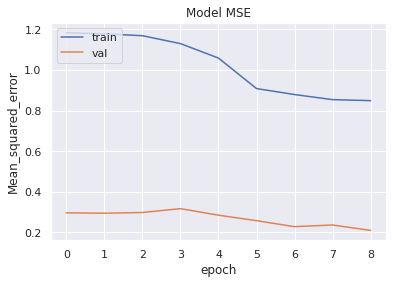

In [30]:
#prueba para el modelo 2
model1.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='MSE', metrics=['mean_squared_error'])
history = model1.fit(x=[xtrain,image1,image2,image3,image4], y = ytrain, validation_split=0.2,batch_size=8,epochs=9,verbose=1,)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('Mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim(0,2)
plt.show() 
red2_mse = history.history['mean_squared_error']
red2_mse_val = history.history['val_mean_squared_error']

# Red 3


Epoch 1/9
45/45 [==============================] - 81s 2s/step - loss: 1.4320 - mean_squared_error: 1.4320 - val_loss: 0.2980 - val_mean_squared_error: 0.2980
Epoch 2/9
45/45 [==============================] - 77s 2s/step - loss: 1.1398 - mean_squared_error: 1.1398 - val_loss: 0.2477 - val_mean_squared_error: 0.2477
Epoch 3/9
45/45 [==============================] - 77s 2s/step - loss: 0.9467 - mean_squared_error: 0.9467 - val_loss: 0.3587 - val_mean_squared_error: 0.3587
Epoch 4/9
45/45 [==============================] - 77s 2s/step - loss: 0.9023 - mean_squared_error: 0.9023 - val_loss: 0.3030 - val_mean_squared_error: 0.3030
Epoch 5/9
45/45 [==============================] - 77s 2s/step - loss: 0.8927 - mean_squared_error: 0.8927 - val_loss: 0.3237 - val_mean_squared_error: 0.3237
Epoch 6/9
45/45 [==============================] - 77s 2s/step - loss: 0.8963 - mean_squared_error: 0.8963 - val_loss: 0.2195 - val_mean_squared_error: 0.2195
Epoch 7/9
45/45 [=============================

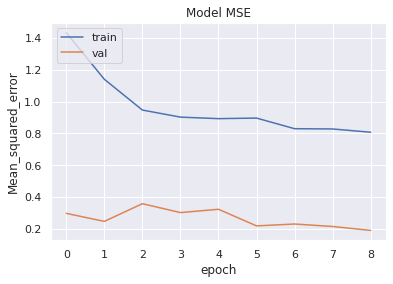

In [32]:
#prueba para el modelo 3
model1.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='MSE', metrics=['mean_squared_error'])
history = model1.fit(x=[xtrain,image1,image2,image3,image4], y = ytrain, validation_split=0.2,batch_size=8,epochs=9,verbose=1,)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('Mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim(0,2)
plt.show() 
red3_mse = history.history['mean_squared_error']
red3_mse_val = history.history['val_mean_squared_error']

In [21]:
#obtenemos los valores para test
vamos_chile=scalerY.inverse_transform(model1([xtest,image1_test,image2_test,image3_test,image4_test])) 

In [ ]:
# exportamos el resultado en un csv
ax = data_house_test[[data_house_test.columns[0]]].astype(str)
ax = ax.rename(columns={ax.columns[0]:'id'})
ax['value'] = vamos_chile
ax.reset_index(drop=True, inplace=True)
ax.to_csv('rusticosv8.csv', index=False)  #nombre del archivo

# Análisis de resultados

Se grafica en conjunto el comportamiento de las 3 arquitecturas probadas. De estas se tiene que al hacer más profundas las redes convolucionales donde se procesan las imágenes se pueden mejorar los resultados. Al agregar skip connections se pueden mejorar levemente los resultados. Es importante igual destacar la cantidad de parámetros con los que cuenta cada red:

*   **Red 1:** 9,517,493
*   **Red 2:** 1,446,085
*   **Red 3:** 7,462,041

En la red 1 se cuentan con una gran cantidad de parámetros aunque se tengan pocas capas convolucionales debido a que no se añadieron capas de pooling. En la red 2 se disminuye considerablemente los parámetros aunque se haya añadido profundidad a la red debido a que se añadieron capas pooling. En la red 3 aumentaron los parámetros debido que se agregaron más capas convolucionales además de añadir skipconnections.


<function matplotlib.pyplot.show>

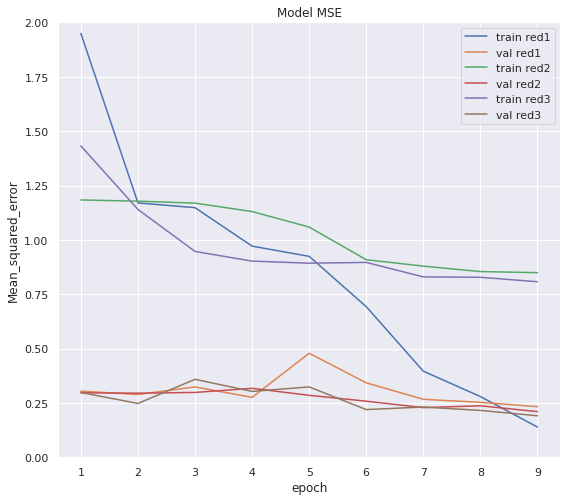

In [41]:
n = [1,2,3,4,5,6,7,8,9] #epoch
plt.figure(figsize=(9, 8))
plt.plot(n,red1_mse,n,red1_mse_val,n,red2_mse,n,red2_mse_val,n,red3_mse,n,red3_mse_val)
plt.title('Model MSE')
plt.ylabel('Mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train red1', 'val red1','train red2', 'val red2','train red3', 'val red3'], loc='upper right')
plt.ylim(0,2)
plt.show